In [1]:
import numpy as np
import tensorflow as tf
import keras

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

#### as you know there are many types of distallation knowledge in deep leanring in this notebook uses Response-based Distillation
this technique will be helpfull if teacher model is pretrained model such as VGGs and ResNet ...etc and student model is light model
### we have three models:
* #### first one is called teacher model trained on the dataset
* #### the remaining two models have the same architechure but:
    * #### one trained as usual same as teacher model
    * #### the second one is trained using distillation with teacher model.
#### the purpose of defining two student model is the comparison between model performance when we use distillation and without distillation learning.
##### results enhanced by 1.5% for this simple architecture also we noted the effect of alpha of the testing result

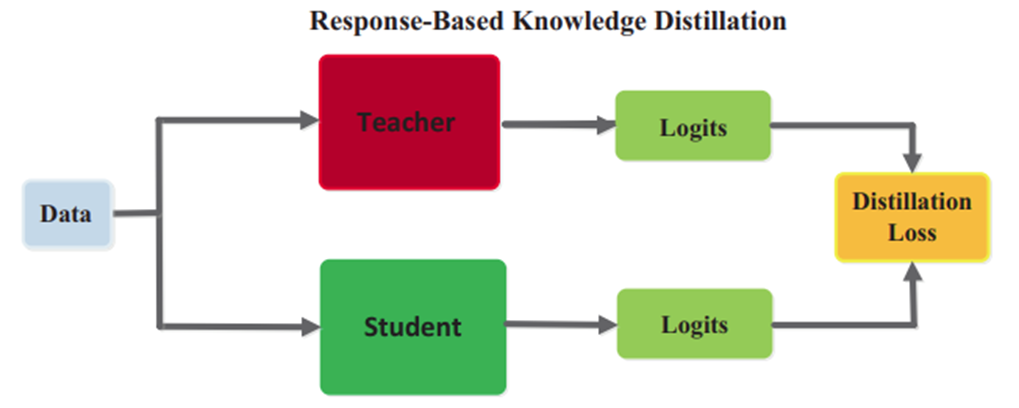

In [2]:
#prepare datasets
batch_size = 16 
(x_train , y_train),(x_test , y_test) = tf.keras.datasets.cifar10.load_data()

x_train = x_train.astype('float')/255.0 
x_train = np.reshape(x_train,(-1,32,32,3))

x_test = x_test.astype('float')/255.0
x_test = np.reshape(x_test,(-1,32,32,3))


170498071/170498071 [==============================] - 9s 0us/step


In [3]:
print("Input Train data  ",x_train.shape)
print("Train data Labels ",y_train.shape)
print("Input Test data   ",x_test.shape)
print("Test data Labels  ",y_test.shape)

Input Train data   (50000, 32, 32, 3)
Train data Labels  (50000, 1)
Input Test data    (10000, 32, 32, 3)
Test data Labels   (10000, 1)


In [4]:
#define teacher model
teacher = tf.keras.Sequential([tf.keras.layers.Input(shape = (32,32,3)),
                              tf.keras.layers.Conv2D(128,(3,3),strides = (2,2), padding = 'same'),
                              tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (1,1), padding = 'same'),
                              tf.keras.layers.LeakyReLU(alpha = 0.2),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.Dropout(0.2),
                               
                              tf.keras.layers.Conv2D(64,(5,5),strides = (2,2), padding = 'same'),
                              tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (1,1), padding = 'same'),
                              tf.keras.layers.LeakyReLU(alpha = 0.2),
                              tf.keras.layers.BatchNormalization(),
                              tf.keras.layers.Dropout(0.2),
                            
                              tf.keras.layers.Conv2D(32,(7,7),strides = (2,2), padding = 'same'),
                              tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (1,1), padding = 'same'),
                              tf.keras.layers.LeakyReLU(alpha = 0.2),
                              tf.keras.layers.BatchNormalization(),
                               
                              tf.keras.layers.Flatten(),
                              tf.keras.layers.Dense(10)
                              ], 
                             name = 'teacher')

teacher.summary()

Model: "teacher"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 128)       0         
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 128)      512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 16, 16, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          2048

In [5]:
#define student model
student = tf.keras.Sequential([tf.keras.layers.Input(shape = (32,32,3)),
                              tf.keras.layers.Conv2D(128,(3,3),strides = (2,2), padding = 'same'),
                              tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (1,1), padding = 'same'),
                              tf.keras.layers.LeakyReLU(alpha = 0.2),
                               
                              tf.keras.layers.Flatten(),
                              tf.keras.layers.Dense(10)
                               ], name = 'student')
student.summary()

Model: "student"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       3584      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_1 (Dense)             (None, 10)                327690    
                                                                 
Total params: 331,274
Trainable params: 331,274
Non-trainable params: 0
_____________________________________________________

In [6]:
#train compile model
teacher.compile(optimizer = tf.keras.optimizers.Adam(),
               loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])

In [7]:
#train teacher model
teacher.fit(x_train , y_train , epochs =4)
#evaluate teacher model
teacher.evaluate(x_test, y_test)#69

Epoch 1/4


2023-06-02 06:06:43.119241: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inteacher/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1563/1563 [==============================] - 19s 6ms/step - loss: 1.3074 - sparse_categorical_accuracy: 0.5343
Epoch 2/4
1563/1563 [==============================] - 9s 6ms/step - loss: 0.9705 - sparse_categorical_accuracy: 0.6552
Epoch 3/4
1563/1563 [==============================] - 9s 6ms/step - loss: 0.8415 - sparse_categorical_accuracy: 0.7067
Epoch 4/4
313/313 [==============================] - 1s 3ms/step - loss: 0.8920 - sparse_categorical_accuracy: 0.6967


[0.8920035362243652, 0.6966999769210815]

In [8]:
#compile and train student model
student.compile(optimizer = tf.keras.optimizers.Adam(),
               loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])
student.fit(x_train , y_train , epochs = 4)
#evaluate student model
student.evaluate(x_test, y_test)

Epoch 1/4
1563/1563 [==============================] - 6s 3ms/step - loss: 1.4113 - sparse_categorical_accuracy: 0.5073
Epoch 2/4
1563/1563 [==============================] - 5s 3ms/step - loss: 1.1528 - sparse_categorical_accuracy: 0.6035
Epoch 3/4
1563/1563 [==============================] - 5s 3ms/step - loss: 1.0537 - sparse_categorical_accuracy: 0.6391
Epoch 4/4
313/313 [==============================] - 1s 2ms/step - loss: 1.1120 - sparse_categorical_accuracy: 0.6209


[1.1119669675827026, 0.6208999752998352]

In [9]:
#define distiller class which will used to train new_student[new_student model was not trained, teacher was trained]
#for training
class Distiller(tf.keras.Model):
    def __init__(self, student , teacher):
        super(Distiller,self).__init__()
        self.teacher = teacher
        self.student = student
    def compile(self,optimizer,metrics,student_loss_fn,distallation_loss_fn,alpha = 0.1,temperature = 3):
               
        super(Distiller,self).compile(optimizer = optimizer,metrics = metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distallation_loss_fn
        self.temperature = temperature#to get soft version of student prediction and soft version of teacher prediction also
        self.alpha = alpha #used to weight student loss in overall loss 
    #define training step
    def train_step(self,data):
        x,y = data
        teacher_prediction = self.teacher(x,training = False)#get teacher prediction and stop training
        print('Teacher prediction...',teacher_prediction)
        #perform gradient descent and update student model weights
        with tf.GradientTape() as tape:
            student_prediction = self.student(x,training = True)#get student prediction and enable training
            student_loss = self.student_loss_fn(y,student_prediction)#get loss as usual (actual and student output)
            
            #distallation loss is the kl divergence between soft lables of teacher and student
            distillation_loss = self.distillation_loss_fn(tf.nn.softmax(teacher_prediction/self.temperature, axis=1),
                                                          tf.nn.softmax(student_prediction/self.temperature, axis=1))
            #total loss is sum of weighted student loss and distillation loss
            loss = self.alpha * student_loss + (1-self.alpha)*distillation_loss
            print('distiller loss : ',loss)   
            trainable_vars = self.student.trainable_variables #get trainable weights of student model 
            gradients = tape.gradient(loss,trainable_vars)#get gradient of each weight
            gradients = [gradient * self.temperature ** 2 for gradient in gradients] 
            self.optimizer.apply_gradients(zip(gradients,trainable_vars)) #apply
            self.compiled_metrics.update_state(y,student_prediction)#update weights
        results={ m.name: m.result()  for m in self.metrics}
        results.update({"student_loss": student_loss, "distillation_loss": distillation_loss})
        print("Train...", results)
        return results
    
    def test_step(self, data):
        
        # Unpack the data
        x, y = data
        
        ## Compute predictions
        y_prediction= self.student(x, training=False)
        
        # calculate the loss
        student_loss= self.student_loss_fn(y, y_prediction)
        
        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)
        
        # Return a dict of performance
        results ={m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        print("Test...", results)
        return results
    

In [25]:
new_student = tf.keras.Sequential([tf.keras.layers.Input(shape = (32,32,3)),
                              tf.keras.layers.Conv2D(128,(3,3),strides = (2,2), padding = 'same'),
                              tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (1,1), padding = 'same'),
                              tf.keras.layers.LeakyReLU(alpha = 0.2),
                               
                              tf.keras.layers.Flatten(),
                              tf.keras.layers.Dense(10)
                               ], name = 'new_student')
# Initialize  distiller
distiller= Distiller(student=new_student, teacher=teacher)

In [26]:
#compile distiller
distiller.compile(optimizer=tf.keras.optimizers.Adam(),
                 metrics=[keras.metrics.SparseCategoricalAccuracy()],
                 student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 distallation_loss_fn=keras.losses.KLDivergence(),
                 alpha=0.2,
                 temperature=8)

In [27]:
# Distill teacher to student
distiller.fit(x_train, y_train, epochs=4)

Epoch 1/4
Teacher prediction... Tensor("teacher/dense/BiasAdd:0", shape=(None, 10), dtype=float32)
distiller loss :  Tensor("add:0", shape=(), dtype=float32)
Train... {'sparse_categorical_accuracy': <tf.Tensor 'Identity_4:0' shape=() dtype=float32>, 'student_loss': <tf.Tensor 'sparse_categorical_crossentropy/weighted_loss/value:0' shape=() dtype=float32>, 'distillation_loss': <tf.Tensor 'kl_divergence/weighted_loss/value:0' shape=() dtype=float32>}
Teacher prediction... Tensor("teacher/dense/BiasAdd:0", shape=(None, 10), dtype=float32)
distiller loss :  Tensor("add:0", shape=(), dtype=float32)
Train... {'sparse_categorical_accuracy': <tf.Tensor 'Identity_4:0' shape=() dtype=float32>, 'student_loss': <tf.Tensor 'sparse_categorical_crossentropy/weighted_loss/value:0' shape=() dtype=float32>, 'distillation_loss': <tf.Tensor 'kl_divergence/weighted_loss/value:0' shape=() dtype=float32>}
1563/1563 [==============================] - 8s 5ms/step - sparse_categorical_accuracy: 0.5121 - student

In [28]:
# Evaluate student on test dataset
distiller.evaluate(x_test, y_test)

Test... {'sparse_categorical_accuracy': <tf.Tensor 'Identity:0' shape=() dtype=float32>, 'student_loss': <tf.Tensor 'sparse_categorical_crossentropy/weighted_loss/value:0' shape=() dtype=float32>}
313/313 [==============================] - 1s 2ms/step - sparse_categorical_accuracy: 0.6369 - student_loss: 1.0650


[0.636900007724762, 1.2369253635406494]